In [1]:
from dask.collection.optimization import cull, compiled, preserve_keys
from dask.optimization_compile import Compiled, compiled_function_cache
import pickle
import dask
import dask.array as da
import numpy as np


def define(apply_markers):
    a = da.arange(4, chunks=2)
    a = (a + 1) * (a - 1)
    # We're going to use this node as an input to
    # multiple ones; don't repeat calculations and
    # allow for parallelism. This is only a good idea if the
    # optimized calculation is expensive.
    if apply_markers:
        a = preserve_keys(a)
    a = ((a < 2) - 10) * ((a > 2) + 10)
    # Showcase deduplication of functions
    if apply_markers:
        a = preserve_keys(a)
    # An input that can't be decompiled into AST
    a = a + np.array([7, 8, 9, 10])
    a = a.sum() + 3
    return a


da_std, = dask.optimize(define(False))
da_com1, _ = cull(compiled(define(False)))
da_com2, _ = cull(compiled(define(True)))
da_std.compute(), da_com1.compute(), da_com2.compute()

(-363, -363, -363)

In [2]:
print(len(pickle.dumps(da_std)))
print(len(pickle.dumps(da_com1)))
print(len(pickle.dumps(da_com2)))
print(pickle.loads(pickle.dumps(da_com1)).compute())
print(pickle.loads(pickle.dumps(da_com2)).compute())

2290
2153
2276
-363
-363


In [3]:
print("Vanilla dask")
print("============")
print("definition")
%timeit define(False)
print("optimization")
a = define(False)
%timeit dask.optimize(a)
print("compute")
%timeit da_std.compute(optimize_graph=False)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_std))

print()
print("source compiled (without intermediate markers)")
print("==============================================")
print("definition")
%timeit define(False)
print("optimization")
a = define(False)
%timeit compiled_function_cache.clear(); cull(compiled(a))
print("compute")
%timeit da_com1.compute(optimize_graph=False)
print("pickle->unpickle")
%timeit pik = pickle.dumps(da_com1); compiled_function_cache.clear(); pickle.loads(pik)

print()
print("source compiled (with intermediate markers)")
print("===========================================")
print("definition")
%timeit define(True)
print("optimization")
a = define(True)
%timeit compiled_function_cache.clear(); cull(compiled(a))
print("compute")
%timeit da_com2.compute(optimize_graph=False)
print("pickle->unpickle")
%timeit pik = pickle.dumps(da_com2); compiled_function_cache.clear(); pickle.loads(pik)

Vanilla dask
definition
2.38 ms ± 65.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
optimization
498 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
compute
5.13 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
72.9 µs ± 921 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

source compiled (without intermediate markers)
definition
2.33 ms ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
optimization
682 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
compute
473 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
264 µs ± 750 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

source compiled (with intermediate markers)
definition
2.38 ms ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
optimization
773 µs ± 3.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
compute
814 µs ± 82.5 µs per loop (mean ± std. dev. 

In [4]:
for k, v in da_com1.dask.items():
    if type(v is tuple) and v and isinstance(v[0], Compiled):
        print("=======================")    
        print(k)
        print(v)
        print("-----------------------")
        print(v[0].source)


('add-d1b015c84d9d576ae48156a3dc591573',)
(<Compiled-1b2c043d>, ('sum-c8d4422ddb698899a9931d0fb9c6a68b', 0), ('sum-c8d4422ddb698899a9931d0fb9c6a68b', 1))
-----------------------
import _operator
import dask.array.core
import numpy


def _compiled(dsk_sum_0, dsk_sum_1):
    dsk_sum_2 = numpy.sum(dask.array.core._concatenate2([dsk_sum_0, dsk_sum_1], axes=(0, )), dtype=numpy.int64, axis=(0, ), keepdims=False)
    return dask.array.core._enforce_dtype(dsk_sum_2, 3, enforce_dtype=numpy.int64, enforce_dtype_function=_operator.add)

('sum-c8d4422ddb698899a9931d0fb9c6a68b', 0)
(<Compiled-0145b4e2>, array([ 7,  8,  9, 10]))
-----------------------
import dask.array.chunk
import dask.array.core
import numpy


def _compiled(ndarray_0):
    dsk_arange_0 = dask.array.chunk.arange(0, 2, 1, 2, numpy.int64)
    dsk_add_0 = dsk_arange_0 + 1
    dsk_sub_0 = dsk_arange_0 - 1
    dsk_mul_0 = dsk_add_0 * dsk_sub_0
    dsk_lt_0 = dsk_mul_0 < 2
    dsk_sub_1 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_0 > 2
    d

In [5]:
for k, v in da_com2.dask.items():
    if type(v is tuple) and v and isinstance(v[0], Compiled):
        print("=======================")    
        print(k)
        print(v)
        print("-----------------------")
        print(v[0].source)


('add-d1b015c84d9d576ae48156a3dc591573',)
(<Compiled-1b2c043d>, ('sum-c8d4422ddb698899a9931d0fb9c6a68b', 0), ('sum-c8d4422ddb698899a9931d0fb9c6a68b', 1))
-----------------------
import _operator
import dask.array.core
import numpy


def _compiled(dsk_sum_0, dsk_sum_1):
    dsk_sum_2 = numpy.sum(dask.array.core._concatenate2([dsk_sum_0, dsk_sum_1], axes=(0, )), dtype=numpy.int64, axis=(0, ), keepdims=False)
    return dask.array.core._enforce_dtype(dsk_sum_2, 3, enforce_dtype=numpy.int64, enforce_dtype_function=_operator.add)

('sum-c8d4422ddb698899a9931d0fb9c6a68b', 0)
(<Compiled-51ee8d04>, ('mul-4b771e2a5e4c977ef86e25b089391d9d', 0), array([ 7,  8,  9, 10]))
-----------------------
import dask.array.core
import numpy


def _compiled(dsk_mul_0, ndarray_0):
    dsk_array_0 = dask.array.core.getter_inline(ndarray_0, (slice(0, 4, None), ))
    dsk_rechunk_0 = dsk_array_0[0:2]
    dsk_add_0 = dsk_mul_0 + dsk_rechunk_0
    return numpy.sum(dsk_add_0, axis=(0, ), keepdims=True, dtype=numpy.i

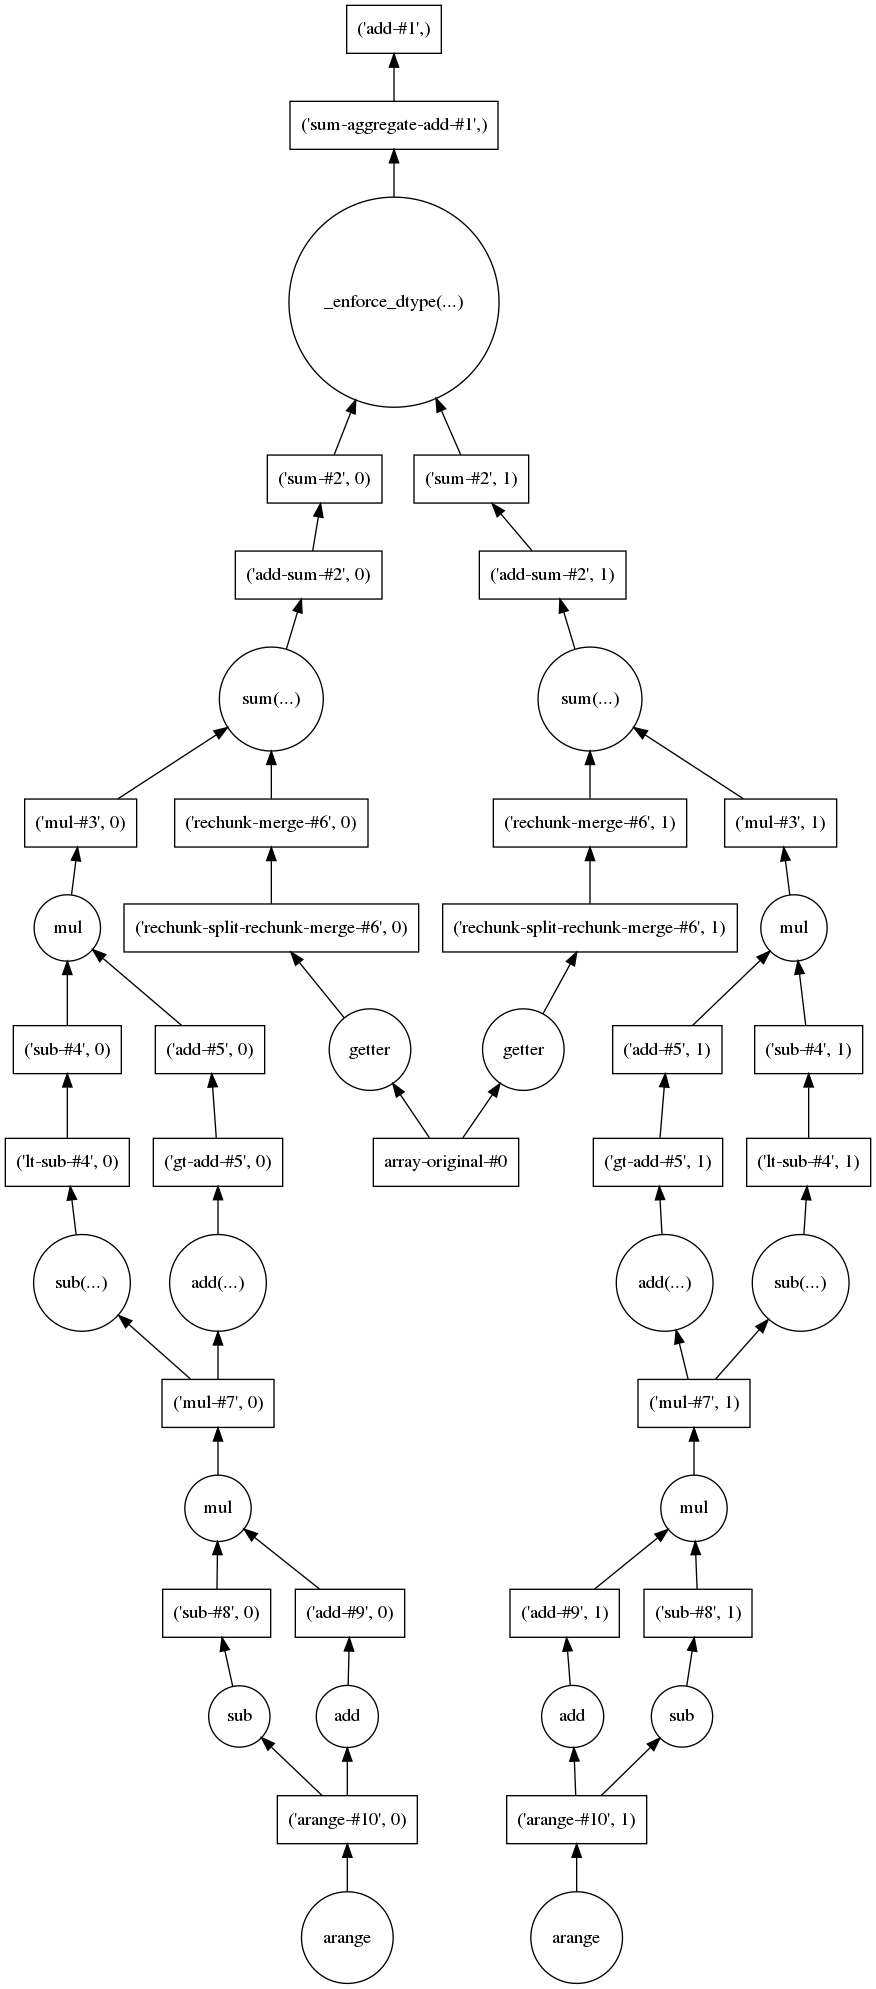

In [6]:
da_std.visualize()

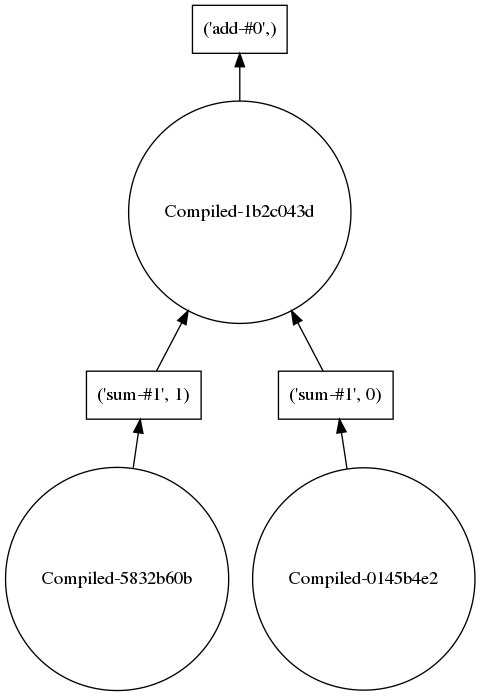

In [7]:
da_com1.visualize()

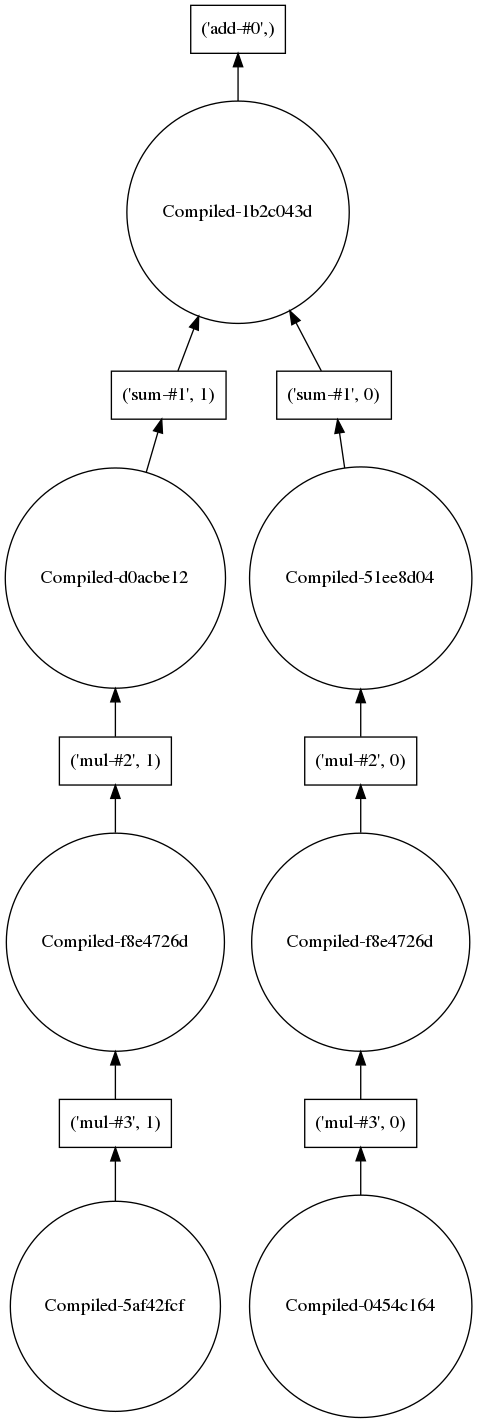

In [8]:
da_com2.visualize()